In [1]:
import os

imdb_dir = '/Users/phoelapyae/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for dir in ['neg', 'pos']:
    path = os.path.join(train_dir, dir)
    for fname in os.listdir(path):
        if fname[-4:] == '.txt':
            f = open(os.path.join(path, fname))
            texts.append(f.read())
            f.close()
            if dir == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
print(len(texts))
print(texts[0])

25000
Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
train_size = 200
validation_size = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [4]:
print(sequences[0])
padded = pad_sequences(sequences, maxlen=maxlen)
print(padded.shape)
print(padded[0])

[777, 16, 28, 4, 1, 115, 2278, 6887, 11, 19, 1025, 5, 27, 5, 42, 2425, 1861, 128, 2270, 5, 3, 6985, 308, 7, 7, 3383, 2373, 1, 19, 36, 463, 3169, 2, 222, 3, 1016, 174, 20, 49, 808]
(25000, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  777   16   28    4    1  115 2278 6887   11   19
 1025    5   27    5   42 2425 1861  128 2270    5    3 6985  308    7
    7 3383 2373    1   19   36  463 3169    2  222    3 1016  174   20
   49  808]


In [5]:
import numpy as np

labels = np.asarray(labels)

In [6]:
print(labels.shape)

(25000,)


In [7]:
indices = np.arange(labels.shape[0])
np.random.shuffle(indices)
data = padded[indices]
labels = labels[indices]

In [8]:
train_texts = data[:train_size]
train_labels = labels[:train_size]

validation_texts = data[train_size:train_size + validation_size]
validation_labels = labels[train_size:train_size + validation_size]

In [9]:
print(train_texts.shape)
print(train_labels.shape)

(200, 100)
(200,)


In [10]:
glove_dir = '/Users/phoelapyae/Downloads/glove.6B.100d.txt'

embeddings_index = {}

f = open(glove_dir)
for line in f:
    splitted = line.split(' ')
    word = splitted[0]
    coefs = np.asarray(splitted[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [11]:
print(len(embeddings_index))

400000


In [17]:
embedding_dim = 100

embedding_metrics = np.zeros((max_words, embedding_dim))
print(embedding_metrics.shape)

(10000, 100)


In [20]:
word_index = tokenizer.word_index
print(len(word_index))

88582


In [21]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_metrics[i] = embedding_vector
print(embedding_metrics[1])

[-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.25259995  0.071624    0.70564997  0.49744001 -0.42063001  0.26148
 -

In [22]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.layers[0].set_weights([embedding_metrics])
model.layers[0].trainable = False

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_texts, train_labels, batch_size=32, epochs=10, validation_data=(validation_texts, validation_labels))
model.save('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 128ms/step - loss: 1.6384 - acc: 0.5063 - val_loss: 0.7563 - val_acc: 0.5100
Epoch 2/10
7/7 [==============================] - 1s 88ms/step - loss: 0.4491 - acc: 0.8302 - val_loss: 1.1757 - val_acc: 0.5048
Epoch 3/10
7/7 [==============================] - 1s 89ms/step - loss: 0.6845 - acc: 0.6809 - val_loss: 0.7075 - val_acc: 0.5488
Epoch 4/10
7/7 [==============================] - 1s 91ms/step - loss: 0.2416 - acc: 0.9187 - val_loss: 0.7782 - val_acc: 0.5308
Epoch 5/10
7/7 [==============================] - 1s 87ms/step - loss: 0.1694 - acc: 0.9815 - val_loss: 0.7760 - val_acc: 0.5256
Epoch 6/10
7/7 [==============================] - 1s 88ms/step - loss: 0.1608 - acc: 0.9850 - val_loss: 0.8338 - val_acc: 0.5409
Epoch 7/10
7/7 [==============================] - 1s 87ms/step - loss: 0.1463 - acc: 0.9490 - val_loss: 0.7230 - val_acc: 0.5658
Epoch 8/10
7/7 [==============================] - 1s 87ms/step - loss: 0.0609 - acc: 1.0000 - va

In [26]:
model.save_weights('pre_train_glove_model_weights.h5')

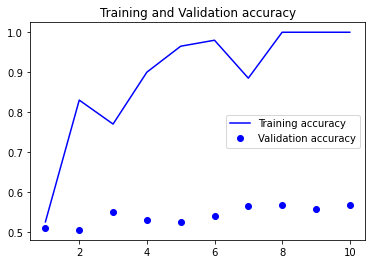

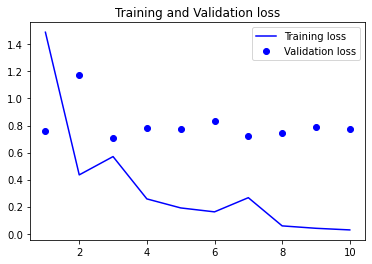

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


In [28]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_texts, train_labels, batch_size=32, epochs=10, validation_data=(validation_texts, validation_labels))

Epoch 1/10
7/7 [==============================] - 1s 124ms/step - loss: 0.6923 - acc: 0.5771 - val_loss: 0.6925 - val_acc: 0.5113
Epoch 2/10
7/7 [==============================] - 1s 142ms/step - loss: 0.4998 - acc: 0.9950 - val_loss: 0.7158 - val_acc: 0.5067
Epoch 3/10
7/7 [==============================] - 1s 127ms/step - loss: 0.2813 - acc: 0.9823 - val_loss: 0.7024 - val_acc: 0.5126
Epoch 4/10
7/7 [==============================] - 1s 120ms/step - loss: 0.1182 - acc: 1.0000 - val_loss: 0.7139 - val_acc: 0.5129
Epoch 5/10
7/7 [==============================] - 1s 105ms/step - loss: 0.0533 - acc: 1.0000 - val_loss: 0.7321 - val_acc: 0.5158
Epoch 6/10
7/7 [==============================] - 1s 97ms/step - loss: 0.0274 - acc: 1.0000 - val_loss: 0.7297 - val_acc: 0.5129
Epoch 7/10
7/7 [==============================] - 1s 100ms/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.7356 - val_acc: 0.5102
Epoch 8/10
7/7 [==============================] - 1s 111ms/step - loss: 0.0086 - acc: 1.000

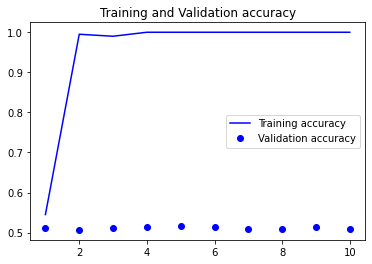

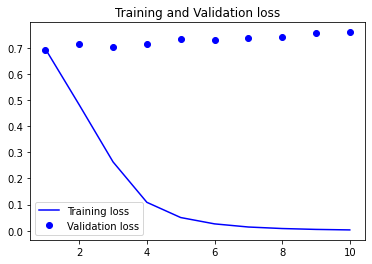

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [35]:
test_dir = os.path.join(imdb_dir, 'test')

texts = []
labels = []

for label in ['neg', 'pos']:
    dir = os.path.join(test_dir, label)
    for fname in sorted(os.listdir(dir)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir, fname))
            texts.append(f.read())
            f.close()
            if label == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [36]:
print(len(texts))

25000


In [37]:
from keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(texts)
test_x = pad_sequences(sequences, maxlen=maxlen)
text_y = np.asarray(labels)

In [38]:
model.load_weights('pre_train_glove_model_weights.h5')
model.evaluate(test_x, text_y)

782/782 [==============================] - 2s 2ms/step - loss: 0.7687 - acc: 0.5656


[0.7686552405357361, 0.565559983253479]